# Image segmentation and neural network quantization

Here are all the import statements needed for all the exercises

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
%load_ext tensorboard
import numpy as np
import matplotlib.pyplot as plt

! pip install tensorflow_model_optimization
import tensorflow_model_optimization as tfmot

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Loading the Sentinel 2 dataset. Images and labels are padded to be 256x256 in size and normalized by their maximum value. 40 images are used for the train partition (X_train, Y_train) and 10 for testing (X_test, Y_test)

In [ ]:
loaded = np.load('sentinel2.npz')
X = loaded['X'].astype(np.float32)  # images dataset
Y = loaded['Y'].astype(np.float32)  # class dataset associated to each pixel (1 means coltivated land, 0 otherwise)
X = np.pad(X, ((0,0),(3,3),(3,3),(0,0)))
Y = np.pad(Y, ((0,0),(3,3),(3,3),(0,0)))
X_train = X[:40]/np.max(X[:40]) # divedes datasets into training and testing
X_test = X[40:]/np.max(X[:40])
Y_train = Y[:40]
Y_test = Y[40:]

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

**[TODO]** Implement the U-net neural network for segmentation as drawn in the lab document.

In [ ]:
# The structure of the U-net NN follows the one that we have seen in the lecture. In the lecture we have seen the Res-Net NN that introduces skip connections between layers.
# This structure is useful cause the NN can better understand the relations between inputs and outputs, and it can perform channel attention or spatial attention.
# Channel attention consists in weighting the feature map with a coefficent evaluated on the input of the layer.
# Spatial attention is very similar and consists in weighting the pixels shared on the features of the image.
# When we introduce skip connection we need to concatenate two output togheter on the features space, for doing so we must consider that they should have the same shape HxW.
# In this NN we see also how encoding and decoding works. Encoding is used to perform features extraction through convolutional layers that reduce the size of the image but increase the number
# of feature maps. In this case for reducing the size of the image we are changing the strides. Strides means the jump that the kernel does on the image during the convolution, and use this
# value equals to 2 means that we are halving the size of the input image.
# Decondig is used to recontruct the image from the features extracted through the encoding. The deconding operation is used also for images segmentation.
# In this case the deconding operation recontruct the image through concatenation with some encoding outputs for adding new features and so more details and then it uses UpSampling2D
# for increasing the size of the image. This is done by adding zeros around the image and then interpolate them with the other pixels.

def unet(input_shape):
  # first layer
  inputs = tf.keras.Input(shape=input_shape)
  x = tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu', padding='same')(inputs) # more we go deeper on the levels and more we increase the number of feature maps extracted, because we want to extract more complex features
  x = tf.keras.layers.BatchNormalization()(x) # batch normalization performs a standardization of the input of the layer by using statistics evaluated on a batch. This is useful to avoid the vanishing and expoding gradient problem
  x = tf.keras.layers.ReLU()(x) # non linear activation function, important cause a linear activation function would make the NN a linear model and so we would lost the advantages of having deep layers
  # the output of this layer is H x W x 64
  # second layer - concatenated to the first
  x = tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu', padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.ReLU()(x)
  # the output of this layer is H x W x 64
  # third layer
  x1 = tf.keras.layers.Conv2D(128, 3, strides=2, activation='relu', padding='same')(x)  # strides = 2 means that the kernel of the convolution will jump 2 pixels at a time on the image, so the result of the convolution will be halved
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.ReLU()(x1)
  # the output of this layer is H/2 x W/2 x 128
  # fourth layer
  x2 = tf.keras.layers.Conv2D(256, 3, strides=2, activation='relu', padding='same')(x1)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.ReLU()(x2)
  # the output of this layer is H/4 x W/4 x 256
  # fifth layer - concatenated to the fourth
  x2 = tf.keras.layers.Conv2D(256, 3, strides=1, activation='relu', padding='same')(x2)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.ReLU()(x2)
  x2 = tf.keras.layers.UpSampling2D(size=(2,2))(x2) # upsample the image by doubling both the dimensions
  x2 = tf.keras.layers.concatenate([x2, x1])  # concatenate the output of the layer with the output of the third layer by the features space, they should have the same image size
  # the output of this layer is H/2 x W/2 x 256+128
  # sixth layer
  x3 = tf.keras.layers.Conv2D(128, 3, strides=1, activation='relu', padding='same')(x2)
  x3 = tf.keras.layers.BatchNormalization()(x3)
  x3 = tf.keras.layers.ReLU()(x3)
  x3 = tf.keras.layers.UpSampling2D(size=(2,2))(x3)
  x3 = tf.keras.layers.concatenate([x3, x]) # concatenate the output of the layer with the output of the first-second layer by the features space, they should have the same image size
  # the output of this layer is H x W x 128+64
  # seventh layer
  x4 = tf.keras.layers.Conv2D(64, 3, strides=1, activation='relu', padding='same')(x3)
  x4 = tf.keras.layers.BatchNormalization()(x4)
  x4 = tf.keras.layers.ReLU()(x4)
  # the output of this layer is H x W x 64

  # note that the last layer is not a Dense layer that performs the classification. This because we are performing image segmentation and not image classification, so the results of the NN is an image and not a class.
  outputs = tf.keras.layers.Conv2D(2, 1, activation='softmax')(x4)  # softmax will create a pdf between the two possible classes, dog or cat
  #outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(x4) # sigmoid maps the input value in a probability between 0 and 1, it doesn't build a pdf. It return the class with the highest probability
  model = tf.keras.Model(inputs=inputs, outputs=outputs)
  return model

Unet_model = unet((256,256,12)) # the input shape is 256x256x12
# Unet_model.summary()

**[TODO]** Compile and train the model (might take some time...)

In [ ]:
Unet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
Unet_model.fit(X_train, Y_train, epochs=80, validation_split=0.2)

Epoch 1/80
1/1 [==============================] - 4s 4s/step - loss: 0.9394 - accuracy: 0.4735 - val_loss: 4.3618 - val_accuracy: 0.7734
Epoch 2/80
1/1 [==============================] - 1s 1s/step - loss: 0.8931 - accuracy: 0.5527 - val_loss: 86.7708 - val_accuracy: 0.7734
Epoch 3/80
1/1 [==============================] - 1s 1s/step - loss: 0.6388 - accuracy: 0.8248 - val_loss: 354.2708 - val_accuracy: 0.7734
Epoch 4/80
1/1 [==============================] - 1s 1s/step - loss: 0.5232 - accuracy: 0.8317 - val_loss: 594.3196 - val_accuracy: 0.7734
Epoch 5/80
1/1 [==============================] - 1s 1s/step - loss: 0.5105 - accuracy: 0.8309 - val_loss: 682.0712 - val_accuracy: 0.7734
Epoch 6/80
1/1 [==============================] - 1s 1s/step - loss: 0.4629 - accuracy: 0.8399 - val_loss: 710.4044 - val_accuracy: 0.7734
Epoch 7/80
1/1 [==============================] - 1s 1s/step - loss: 0.4232 - accuracy: 0.8433 - val_loss: 682.3586 - val_accuracy: 0.7734
Epoch 8/80
1/1 [==============

**[TODO]** Test the model on the test set and measure the accuracy.

1/1 [==============================] - 0s 203ms/step - loss: 0.6479 - accuracy: 0.7351


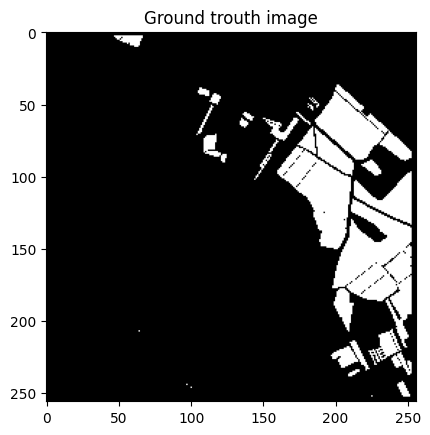

1/1 [==============================] - 0s 166ms/step


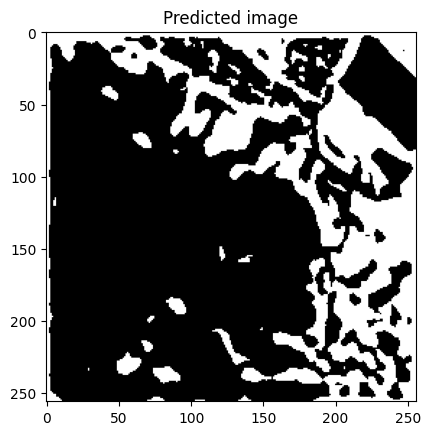

In [ ]:
Unet_model.evaluate(X_test, Y_test)

image = Y_test[1]
plt.imshow(image, 'gray')
plt.title('Ground trouth image')
plt.show()

predict_im = Unet_model.predict(X_test[1].reshape(1,256,256,12))
predict_im = np.squeeze(predict_im)
predict_im = np.argmax(predict_im, axis=-1)
plt.imshow(predict_im, 'gray')
plt.title('Predicted image')
plt.show()

**[TO DO]** Convert model to TFLite with 8-bit weight quantization

In [ ]:
# in our model we have many parameters and each is saved as float32. This cost to use a lot of memory space, so we want to reduce the dimension of these parameters. For doing so we can
# perform quantization, so we can quantize each float parameter to an int parameter that can be rappresented with only 8 bits.
# PTQ (Post Training Quantization) quantize each parameter on an already trained neural network. This type of quantization is the faster and the easiest to implement, but it can reduce the
# accuracy of the model, cause the quantization is chaning the optimal parameters that the model has found during the training.

converter = tf.lite.TFLiteConverter.from_keras_model(Unet_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

quantized_model = converter.convert()
with open("quantized_model.tflite", "wb") as f:
  f.write(quantized_model)

**[TODO]** Test the accuracy of the quantized model by writing your own "evaluate" function. Remember that TFLite interpreter can only process one sample at a time, not a batch.

In [ ]:
# Initialize the interpreter
interpreter = tf.lite.Interpreter('quantized_model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

def evaluate(interpreter, X_test, Y_test):
  accuracies = []

  for i, (input_data, true_class) in enumerate(zip(X_test, Y_test)):
    input_data = input_data.astype(input_details[0]['dtype']) # read the image from the test dataset

    interpreter.set_tensor(input_details[0]['index'], np.expand_dims(input_data, axis=0)) # set the input tensor with the image and add a dimension for the batch

    interpreter.invoke()  # run the inference on the image
    output_data = interpreter.get_tensor(output_details[0]['index'])  # get the output tensor of the model
    predicted_class = np.squeeze(output_data) # remove the batch dimension
    predicted_class = np.argmax(predicted_class, axis=2)  # get the class with the highest probability

    true_class = np.squeeze(true_class) # remove the batch dimension
    accuracy = np.mean(predicted_class == true_class) # evaluate the accuracy of the model
    accuracies.append(accuracy) # save the accuracy of the model

    print(f"Image {i+1} - Accuracy: {accuracy}")  # print the accuracy of the model

    # plt.imshow(true_class, 'gray')  # show the image
    # plt.title('Ground trouth image')
    # plt.show()

    # plt.imshow(predicted_class, 'gray') # show the predicted image
    # plt.title('Predicted image')
    # plt.show()
  return np.mean(accuracies)
# Call the evaluate function
accuracy = evaluate(interpreter, X_test, Y_test)
print(f"Mean accuracy: {accuracy}")

original_predictions = Unet_model.predict(X_test)
original_predictions = (original_predictions > 0.5).astype(np.uint8)

Image 1 - Accuracy: 0.7625885009765625
Image 2 - Accuracy: 0.7811737060546875
Image 3 - Accuracy: 0.8894500732421875
Image 4 - Accuracy: 0.642120361328125
Image 5 - Accuracy: 0.6657562255859375
Image 6 - Accuracy: 0.6487274169921875
Image 7 - Accuracy: 0.8273773193359375
Image 8 - Accuracy: 0.715728759765625
Image 9 - Accuracy: 0.8212127685546875
Image 10 - Accuracy: 0.63031005859375
Mean accuracy: 0.7384445190429687
1/1 [==============================] - 0s 56ms/step


**[TODO]** Finetune the Keras model using quantization-aware training and measure the accuracy on the test set after actually quantizing it

In [ ]:
# the best way to quantize the parameter is through QAT (Quantization Aware Training). This method consists in training the model to find the best parameters that can be quantized in int8.
# So during the training the model will be aware that the parameters need to be quantized, so it will find the best values to be quantized.
# A model quantized with QAT can perform similar to the original model, but with a lower memory occupation. Note that QAT model need an ad-hoc training and calibration.

# cannot apply QAT to batch normalizer layers
quant_aware_model = tfmot.quantization.keras.quantize_model(Unet_model)
quant_aware_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
quant_aware_model.fit(X_train, Y_train, epochs=50)

converter = tf.lite.TFLiteConverter.from_keras_model(quant_aware_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_aware_model = converter.convert()

RuntimeError: Layer batch_normalization_42:<class 'tf_keras.src.layers.normalization.batch_normalization.BatchNormalization'> is not supported. You can quantize this layer by passing a `tfmot.quantization.keras.QuantizeConfig` instance to the `quantize_annotate_layer` API.